In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from sklearn.metrics import classification_report
import time 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import keras_cv

image_size = (139, 139)

effnetv2_model = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b2_imagenet",  #"efficientnetv2_s_imagenet",
    #input_shape=(139, 139, 3),
    input_tensor=image_input,
)

Using TensorFlow backend
35526136/35526136 [==============================] - 0s 0us/step


In [3]:
# Add a new classification layer
x = effnetv2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.5)(x)
class_outputs = Dense(41, activation='softmax')(x)

# Create the model
model = Model(inputs=effnetv2_model.input, outputs=class_outputs)

#model.summary()

In [4]:
import keras
from keras.optimizers import Lion

batch_size = 128

# Load the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_dataset = train_datagen.flow_from_directory(
    '/kaggle/input/majorplantdiseasedetection/dataset/train',
    target_size=(180, 180),  #(299, 299)
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the validation data
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_dataset = val_datagen.flow_from_directory(
    '/kaggle/input/majorplantdiseasedetection/dataset/train',
    target_size=(180, 180),   #299,299
    batch_size=batch_size,
    class_mode='categorical'
)

# Define parameters
num_epochs = 40
num_classes = 41

# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=LossScaleOptimizer(Lion(learning_rate=1e-3, weight_decay=True), initial_scale=32768.0, dynamic_growth_steps=10000),
              optimizer= keras.optimizers.Lion(learning_rate=1e-3), 
              metrics=['accuracy'])

# Train the model and store the history
history = model.fit(train_dataset,
                    batch_size=128,
                    epochs=num_epochs,
                    validation_data=val_dataset,
                    verbose=1
                   )



Found 33111 images belonging to 41 classes.
Found 33111 images belonging to 41 classes.
Epoch 1/40


2024-04-28 16:03:25.222885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


259/259 [==============================] - 615s 2s/step - loss: 0.5662 - accuracy: 0.8451 - val_loss: 0.1830 - val_accuracy: 0.9434
Epoch 2/40
259/259 [==============================] - 453s 2s/step - loss: 0.2632 - accuracy: 0.9210 - val_loss: 0.1507 - val_accuracy: 0.9510
Epoch 3/40
259/259 [==============================] - 458s 2s/step - loss: 0.2196 - accuracy: 0.9339 - val_loss: 0.1667 - val_accuracy: 0.9521
Epoch 4/40
259/259 [==============================] - 409s 2s/step - loss: 0.1914 - accuracy: 0.9432 - val_loss: 0.1269 - val_accuracy: 0.9607
Epoch 5/40
259/259 [==============================] - 486s 2s/step - loss: 0.1692 - accuracy: 0.9495 - val_loss: 0.0977 - val_accuracy: 0.9724
Epoch 6/40
259/259 [==============================] - 405s 2s/step - loss: 0.1617 - accuracy: 0.9518 - val_loss: 0.0942 - val_accuracy: 0.9700
Epoch 7/40
259/259 [==============================] - 415s 2s/step - loss: 0.1478 - accuracy: 0.9566 - val_loss: 0.0889 - val_accuracy: 0.9723
Epoch 8/40

In [5]:
# Save the model in native Keras format
model.save('plant_disease_model_effnetv2.keras')

import joblib

# Save the model using joblib
joblib.dump(model, 'plant_disease_model_effnetv2.pkl')


['plant_disease_model_effnetv2.pkl']

In [6]:
# Save model weights
model.save_weights('model_weights.h5')

# Save model configurations (architecture, optimizer state, etc.)
model_config = model.get_config()
with open('model_config.pkl', 'wb') as config_file:
    joblib.dump(model_config, config_file)


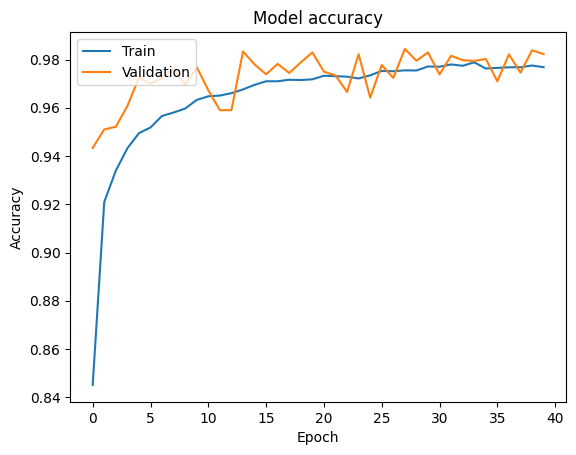

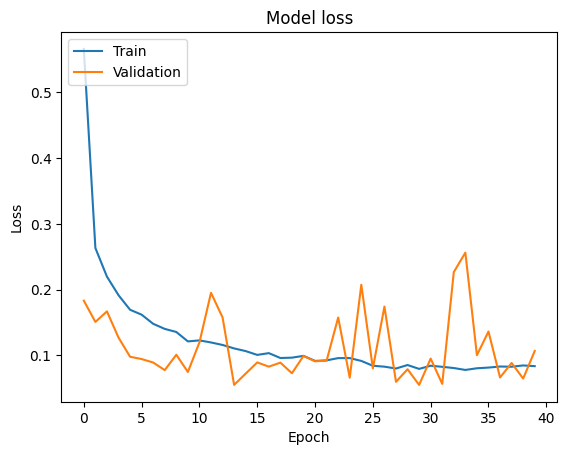

In [7]:
# Plot the metrics to visualize the training process
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_metrics(history)

In [9]:
# Load the test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_dataset = test_datagen.flow_from_directory(
    '/kaggle/input/majorplantdiseasedetection/dataset/test',
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to maintain the order for evaluation
)

# Evaluate the model on the test data
start_time = time.time()
evaluation_result = model.evaluate(test_dataset)
print("Time taken to evaluate the model: " + str(time.time() - start_time))

# Print the evaluation result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

# Make predictions on the test set
y_pred = model.predict(test_dataset)
y_pred_bool = np.argmax(y_pred, axis=1)

# Get true labels directly from test_dataset
true_labels = test_dataset.labels

# Print the classification report
print(classification_report(true_labels, y_pred_bool, digits=4))

# Optionally, you can save the evaluation results for further analysis
np.savetxt("y_true.txt", true_labels, fmt="%d")
np.savetxt("y_pred.txt", y_pred_bool, fmt="%d")


Found 8339 images belonging to 41 classes.
66/66 [==============================] - 51s 784ms/step - loss: 0.1967 - accuracy: 0.9677
Time taken to evaluate the model: 51.732882499694824
Test Loss: 0.1966528296470642
Test Accuracy: 0.9677419066429138
66/66 [==============================] - 37s 538ms/step
              precision    recall  f1-score   support

           0     0.9919    0.9762    0.9840       126
           1     0.9764    1.0000    0.9880       124
           2     1.0000    1.0000    1.0000        55
           3     0.9818    0.9848    0.9833       329
           4     0.9951    0.9714    0.9831       210
           5     0.9883    0.9941    0.9912       170
           6     0.5714    0.8000    0.6667        10
           7     0.8333    0.5000    0.6250        10
           8     0.9000    0.9000    0.9000        10
           9     1.0000    0.7000    0.8235        10
          10     0.9000    0.9000    0.9000        10
          11     0.7910    0.4569    0.5792  